In [12]:
####################################################################################
# This test code shows how new_basin_cities looks like
# basin at each city
distance=100
####################################################################################
h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
basin_cities_path = f'{h08dir}/global_city/dat/riv_num_/basin_to_cities_{distance}km.json'

with open(basin_cities_path, 'r') as json_file:
    tmp = json.load(json_file)
    
sorted_keys = sorted(tmp.keys(), key=lambda k: float(k))

for key in sorted_keys:
    value = tmp[key]
    if 4 < len(value) and float(key) < 100:
        print(f'key{key}, len: {len(value)}')
        print(value)
        print('-----------------------------------------')

key1.0, len: 12
['30', '228', '263', '274', '327', '453', '872', '1217', '1277', '1410', '1420', '1703']
-----------------------------------------
key2.0, len: 9
['28', '261', '480', '650', '729', '1101', '1333', '1434', '1491']
-----------------------------------------
key3.0, len: 48
['19', '37', '150', '194', '283', '304', '335', '353', '372', '376', '407', '416', '421', '437', '553', '648', '694', '741', '754', '756', '794', '832', '868', '909', '920', '924', '934', '954', '1001', '1052', '1131', '1154', '1159', '1172', '1248', '1269', '1320', '1380', '1463', '1470', '1496', '1510', '1515', '1523', '1534', '1538', '1608', '1660']
-----------------------------------------
key4.0, len: 16
['9', '71', '76', '118', '200', '579', '691', '729', '746', '1333', '1551', '1579', '1667', '1675', '1676', '1747']
-----------------------------------------
key5.0, len: 33
['5', '94', '119', '140', '155', '196', '257', '343', '550', '597', '629', '689', '767', '789', '803', '836', '837', '866', '9

In [48]:
##########################################################
# volga river basin
# rivnum=3
# Moscow=citynum(19)
# 48 cities
##########################################################
# xaxis = city num (later city_name)
# sorted_order =  upstream to downstream (topological sort)
# yaxis = availability(annual discharge) as line plot
   # availabilityはdemandが減った後の値を使わなくてはいけないのではないか？ 
# yaxis2 = population(city population) as bar plot
##########################################################

# get city num
uid = 3.0

city_list = tmp[f'{uid}']
city_list = [int(i) for i in city_list]

# remove overlap
h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
overlap_path = f'{h08dir}/global_city/dat/cty_lst_/gpw4/overlap_hidden_only.txt'
with open(overlap_path, 'r') as f:
    numbers = [int(line.strip()) for line in f]
city_list_removed = [num for num in city_list if num not in numbers]
city_list_removed = [int(i) for i in city_list_removed]

print(city_list_removed)

[19, 37, 150, 194, 304, 335, 353, 372, 376, 407, 416, 421, 437, 553, 648, 694, 741, 754, 756, 794, 832, 868, 909, 920, 924, 934, 954, 1001, 1052, 1131, 1154, 1159, 1172, 1248, 1269, 1320, 1380, 1463, 1470, 1496, 1510, 1515, 1534, 1538, 1608, 1660]


In [26]:
####################################################################################
# this code defines function to create edges for specific drainage basin
# edgesは2都市間のupstreamとdownstreamの関係をすべて保存したリスト
####################################################################################

import numpy as np
import json
from collections import defaultdict

# load files
h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
basin_cities_path = f'{h08dir}/global_city/dat/riv_num_/basin_to_cities_{distance}km.json'

with open(basin_cities_path, 'r') as json_file:
    new_basin_to_cities = json.load(json_file)
    
def l_coordinate_to_tuple(lcoordinate, a=2160, b=4320):
    lat_l = ((lcoordinate - 1) // b)
    lon_l = (lcoordinate) % b - 1
    return (lat_l, lon_l)

def nxtl2nxtxy(rgnfile, upperindex, leftindex):
    vfunc = np.vectorize(l_coordinate_to_tuple, otypes=[tuple])
    riv_nxtxy = np.empty(rgnfile.shape, dtype=tuple)
    mask = ~np.isnan(rgnfile)
    riv_nxtxy[mask] = vfunc(rgnfile[mask])
    riv_nxtxy_shape = (riv_nxtxy.shape[0], riv_nxtxy.shape[1], 2)
    
    riv_nxtxy_lst = []
    for row in riv_nxtxy:
        for y, x in row:
            modified_y = y - upperindex
            modified_x = x - leftindex
            riv_nxtxy_lst.append((modified_y, modified_x))

    riv_nxtxy_cropped = np.array(riv_nxtxy_lst).reshape(riv_nxtxy_shape)
    riv_nxtxy_cropped = riv_nxtxy_cropped.astype(int)
    return riv_nxtxy_cropped

# rivnextlonlat 
rivnxl_path = f"{h08dir}/global_city/dat/riv_nxl_/rivnxl.CAMA.gl5"
rivnxl_gl5 = np.fromfile(rivnxl_path, 'float32').reshape(2160, 4320)
riv_nxlonlat_cropped = nxtl2nxtxy(rivnxl_gl5, 0, 0)

def is_valid_edge(city1, city2, coords_dict):
    for coord, city_list in coords_dict.items():
        if len(city_list) > 1:
            if city1 in city_list and city2 in city_list:
                if city1 > city2:
                    continue
                else:
                    city1, city2 = None, None
                    
    if city1 and city2:
        return True
    else:
        return False

def updown(new_basin_to_cities, uid_str='3.0', distance=100):
    city_list = new_basin_to_cities[uid_str]
    city_list = [int(i) for i in city_list]
    
    # remove overlap
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    overlap_path = f'{h08dir}/global_city/dat/cty_lst_/gpw4/overlap_hidden_only.txt'
    with open(overlap_path, 'r') as f:
        numbers = [int(line.strip()) for line in f]
    city_list_removed = [num for num in city_list if num not in numbers]
    city_list_removed = [int(i) for i in city_list_removed]
    
    # rivout
    rivout_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
    rivout_gl5 = np.fromfile(rivout_path, dtype='float32').reshape(2160, 4320)
    
    # coord of purficication
    coords_a = []
    #special_lst = [2, 1089, 1288, 1620]
    for city_num in city_list_removed:
    #for city_num in special_lst:
        # rivnum
        rivnum_path = f'{h08dir}/global_city/dat/riv_num_/rivnum.CAMA.gl5'
        rivnum_gl5 = np.fromfile(rivnum_path, dtype='float32').reshape(2160, 4320)

        # prf
        prf_dir = f'{h08dir}/global_city/dat/cty_prf_'
        prf_path = f'{prf_dir}/vld_cty_/city_{city_num:08}.gl5'
        prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)

        # int
        int_dir = f'{h08dir}/global_city/dat/cty_int_/{distance}km_samebasin'
        int_path = f'{int_dir}/city_{city_num:08}.gl5'
        intake = np.fromfile(int_path, dtype='float32').reshape(2160, 4320)
        
        # 1. prfのみが対象流域内(uid)
        # 2. intのみが対象流域内(uid)
        # 3. prfとintどちらもが対象領域内(uid)
        uid_int = int(uid)
        prf_coord = np.where((prf == 1) & (rivnum_gl5 == uid_int))
        int_coord = np.where((intake == 1) & (rivnum_gl5 == uid_int))
        
        if prf_coord[0].size != 0 and int_coord[0].size != 0:
            
            prf_runout = rivout_gl5[prf_coord][0] * 60 * 60 * 24 * 365 / (1000)
            int_runout = rivout_gl5[int_coord][0] * 60 * 60 * 24 * 365 / (1000)
            
            if prf_runout > int_runout:
                larger_coord = prf_coord
            else:
                larger_coord = int_coord
                
        elif prf_coord[0].size != 0 and int_coord[0].size == 0:
            larger_coord = prf_coord
            
        elif prf_coord[0].size == 0 and int_coord[0].size != 0:
            larger_coord = int_coord
            
        else:
            larger_coord = prf_coord
            continue
            
        coords_a.append([larger_coord, city_num])
        
####################################################################################
# 1. 同流域内で取水点がかぶっている都市を取水点ごとにリストにする
####################################################################################

    # 同じ座標に対して city_num のリストを作成するための辞書
    coords_dict = defaultdict(list)

    # coords_a の要素をループして座標をキーに city_num をリストに追加
    for coord, city_num in coords_a:
        coord_tuple = (tuple(coord[0]), tuple(coord[1]))
        coords_dict[coord_tuple].append(city_num)

####################################################################################
# check what's happening in 1089, 1288, 1620
####################################################################################
        
    # down
    edges = []
    riv_path_array = np.zeros((2160, 4320))
    
    # city_num loop 
    for idx in range(len(coords_a)):
        
        cityup = coords_a[idx][1]
        print(f'-----------------------------------------------------------')
        print(f'cityup: {cityup}')
        print(f'coord: {(coords_a[idx][0][0][0], coords_a[idx][0][1][0])}')
        
        visited_coords = set()
        
        # coords_a[idx][0] = (array([732]), array([3086]))
        riv_path_array[coords_a[idx][0][0][0], coords_a[idx][0][1][0]] = idx

        # coordinates of prf and intake
        coords_b = coords_a.copy()
        coords_b.pop(idx) 
        
        if len(coords_a) > 0:
            target_coord = (coords_a[idx][0][0][0], coords_a[idx][0][1][0])
            
            while True:
                if target_coord in visited_coords:
                    break
                visited_coords.add(target_coord)
                
                next_coord = riv_nxlonlat_cropped[target_coord[0], target_coord[1]]
                if next_coord.size == 0 or next_coord.shape != (2,):
                    break
                
                next_coord = (next_coord[0], next_coord[1])
                riv_path_array[next_coord[0], next_coord[1]] = idx
                target_coord = next_coord

        for coord in coords_b:
            citydwn = coord[1]
            
            if coord[0][0].size == 0:
                continue
            else:
                standard_coord = (coord[0][0][0], coord[0][1][0])
                if standard_coord in visited_coords:
                    edge_flag = is_valid_edge(cityup, citydwn, coords_dict)
                    if edge_flag:
                        print(f'citydwn: {citydwn}')
                        edges.append((cityup, citydwn))
                    else:
                        continue
                else:
                    continue
                    
    # edgesは2都市間のupstreamとdownstreamの関係をすべて保存したリスト
    return edges, riv_path_array, coords_a, city_list_removed
    
edges, riv_path_array, coords_a, city_list_removed = updown(new_basin_to_cities, uid_str='3.0')

-----------------------------------------------------------
cityup: 19
coord: (410, 2608)
citydwn: 372
citydwn: 376
citydwn: 437
citydwn: 553
citydwn: 648
citydwn: 756
citydwn: 909
citydwn: 920
citydwn: 1052
-----------------------------------------------------------
cityup: 37
coord: (645, 2785)
citydwn: 1660
-----------------------------------------------------------
cityup: 150
coord: (644, 2876)
-----------------------------------------------------------
cityup: 194
coord: (600, 2750)
-----------------------------------------------------------
cityup: 304
coord: (618, 2722)
-----------------------------------------------------------
cityup: 335
coord: (407, 2876)
citydwn: 372
citydwn: 421
citydwn: 437
citydwn: 553
citydwn: 648
citydwn: 756
citydwn: 920
citydwn: 934
-----------------------------------------------------------
cityup: 353
coord: (402, 2683)
citydwn: 372
citydwn: 376
citydwn: 437
citydwn: 553
citydwn: 648
citydwn: 756
citydwn: 920
citydwn: 1052
------------------------

In [145]:
#############################################################
# トポロジカルソート
# edgesが必要
uid_str = '3.0'
#############################################################

from collections import defaultdict, deque

def topological_sort(edges):
    # 都市間の流れを構築
    graph = defaultdict(list)
    indegree = defaultdict(int)
    nodes = set()
    
    for upstream, downstream in edges:
        graph[upstream].append(downstream)
        indegree[downstream] += 1
        nodes.add(upstream)
        nodes.add(downstream)
    
    # トポロジカルソート
    queue = deque([node for node in nodes if indegree[node] == 0])
    sorted_order = []
    
    while queue:
        node = queue.popleft()
        sorted_order.append(node)
        
        for neighbor in graph[node]:
            indegree[neighbor] -= 1
            if indegree[neighbor] == 0:
                queue.append(neighbor)
    print("Sorted order of cities from upstream to downstream")
    print(sorted_order)
    print("------------------------------------------------------------------")
    
    return sorted_order

#edges, riv_path_array, coords_a, city_list_removed = updown(new_basin_to_cities, uid_str='3.0')
sorted_order = topological_sort(edges)
xaxis = [f'{i}' for i in sorted_order]
print(xaxis)

Sorted order of cities from upstream to downstream
[1154, 1159, 19, 1172, 924, 37, 1463, 954, 335, 1496, 1380, 741, 1510, 1131, 1515, 1269, 1534, 1608, 1660, 421, 1001, 416, 1470, 754, 794, 934, 909, 353, 1052, 376, 756, 648, 372, 553, 437, 920]
------------------------------------------------------------------
['1154', '1159', '19', '1172', '924', '37', '1463', '954', '335', '1496', '1380', '741', '1510', '1131', '1515', '1269', '1534', '1608', '1660', '421', '1001', '416', '1470', '754', '794', '934', '909', '353', '1052', '376', '756', '648', '372', '553', '437', '920']


In [68]:
import pandas as pd

h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
updown_path = f'{h08dir}/wsi/dat/availablewater/updown_availability_100km_abandon.txt'
df_new = pd.read_csv(updown_path, delimiter='|', header=None)
df_new.columns = df_new.iloc[0]
df_new = df_new[1:].reset_index(drop=True)
df_new = df_new.infer_objects()
df_new.head(5)

# population
population = [df_new.loc[df_new['index'] == f'{city_num}', 'pop'].values[0] for city_num in sorted_order]
population = [int(float(i)) for i in population]
print(population)

[431397, 398269, 11578511, 399242, 529768, 8212381, 321880, 486030, 1362467, 312066, 344722, 628827, 320404, 421490, 377381, 315001, 300150, 300793, 315541, 1067583, 478042, 1068820, 328196, 645251, 588376, 513985, 489621, 1272022, 461240, 1146380, 493562, 719898, 1020661, 838370, 719659, 520592]


In [67]:
#############################################################
# availabiilty
# only from targeted river basin
# sorted_orderが必要
riv_num=3
#############################################################

import os

availability = []

h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
rivnum_path = f'{h08dir}/global_city/dat/riv_num_/rivnum.CAMA.gl5'
rivout_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
prf_dir = f'{h08dir}/global_city/dat/cty_prf_'
int_dir = f'{h08dir}/global_city/dat/cty_int_/{distance}km_samebasin'

rivnum_gl5 = np.fromfile(rivnum_path, dtype='float32').reshape(2160, 4320)
rivout_gl5 = np.fromfile(rivout_path, dtype='float32').reshape(2160, 4320)

for city_num in sorted_order:
    
    prf_path = f'{prf_dir}/vld_cty_/city_{city_num:08}.gl5'
    int_path = f'{int_dir}/city_{city_num:08}.gl5'
    
    if not os.path.exists(prf_path):
        print(f'{city_num} is invalid prf')

    else:
        prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)
        intake = np.fromfile(int_path, dtype='float32').reshape(2160, 4320)
        
        int_rivnum = rivnum_gl5[intake==1]
        
        if int_rivnum.size != 0:
            
            prf_coord = np.where((prf == 1) & (rivnum_gl5 == riv_num))
            int_coord = np.where((intake==1) & (rivnum_gl5 == riv_num))
            
            if prf_coord[0].size != 0 and int_coord[0].size != 0:
                
                prf_runout = rivout_gl5[prf_coord][0] * 60 * 60 * 24 * 365 / (1000)
                int_runout = rivout_gl5[int_coord][0] * 60 * 60 * 24 * 365 / (1000)
                
                if prf_runout > int_runout:
                    source_coord = prf_coord
                else:
                    source_coord = int_coord
                    
            elif prf_coord[0].size != 0 and int_coord[0].size == 0:
                source_coord = prf_coord
                
            elif prf_coord[0].size == 0 and int_coord[0].size != 0:
                source_coord = int_coord
                
            else:
                print('Error no prf no int')

        discharge = rivout_gl5[source_coord][0] * 60 * 60 * 24 * 365 / (1000)

    availability.append(int(float(discharge)))
    
print(availability)

[383649452, 1274999001, 2374926392, 9257692392, 4999780019, 336659580, 557257627, 698171869, 619759392, 1274812619, 3738820943, 2331402031, 1211113471, 1708595103, 4129535, 423376158, 14633498313, 6056809087, 1153661778, 12018591337, 17529078645, 1844611842, 10721222964, 6497701584, 58667374764, 109858778064, 27796147731, 81353119608, 190273764744, 205823567160, 374262972336, 380462098464, 382244639328, 415303985808, 417507248448, 418473164592]


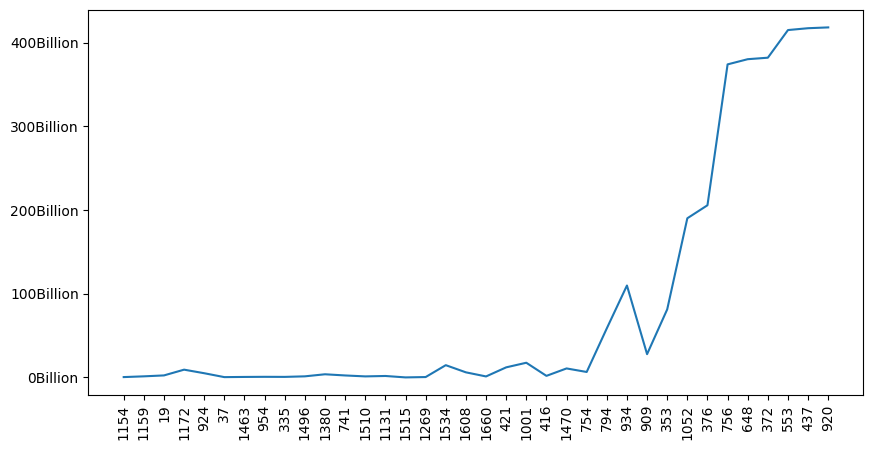

In [65]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def billions(x, pos):
    return '%1.0fBillion' % (x * 1e-9)

formatter = FuncFormatter(billions)

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(xaxis, availability)

ax.yaxis.set_major_formatter(formatter)

ax.set_xticks(range(len(xaxis)))
ax.set_xticklabels(xaxis, rotation=90)

plt.show()

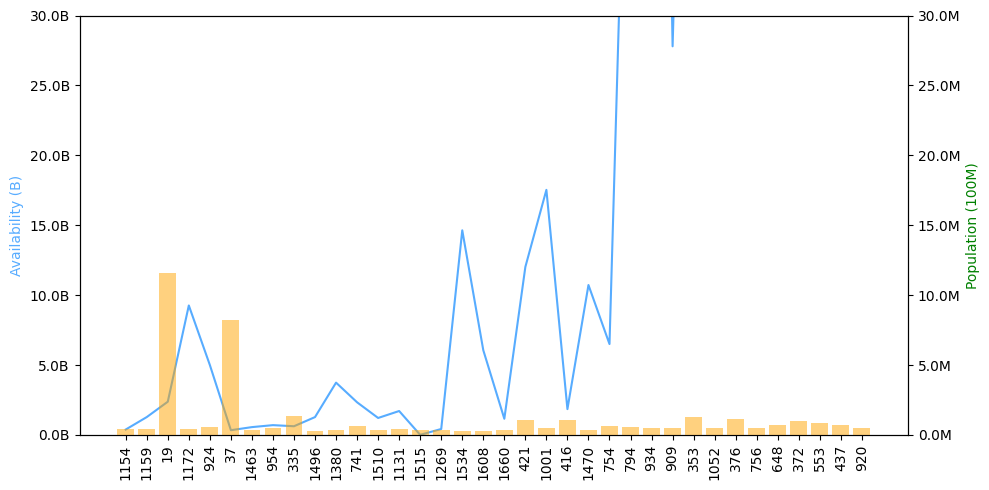

In [75]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# 例としてデータを用意
xaxis = [f'{i}' for i in sorted_order]

# y軸を1e9のオーダーで表示するフォーマッターを定義
def billions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fB' % (x * 1e-9)

# y軸を100ミリオンのオーダーで表示するフォーマッターを定義
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

availability_formatter = FuncFormatter(billions)
population_formatter = FuncFormatter(millions)

# プロットの作成
fig, ax1 = plt.subplots(figsize=(10, 5))

# availabilityの折れ線グラフ
ax1.plot(xaxis, availability, color='#57acff', label='Availability')
ax1.set_ylabel('Availability (B)', color='#57acff')
ax1.yaxis.set_major_formatter(availability_formatter)
ax1.set_ylim(0, 30e9)

# x軸ラベルを90度回転
ax1.set_xticks(range(len(xaxis)))
ax1.set_xticklabels(xaxis, rotation=90)

# ツイン軸の作成
ax2 = ax1.twinx()

# populationの棒グラフ
ax2.bar(xaxis, population, alpha=0.5, color='orange', label='Population')
ax2.set_ylabel('Population (100M)', color='g')
ax2.yaxis.set_major_formatter(population_formatter)
ax2.set_ylim(0, 30e6)

# グラフの表示
fig.tight_layout()
plt.show()

In [152]:
# population and ava_int after mod is needed
sorted_order = topological_sort(edges)

h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
lonlat_path = f'{h08dir}/wsi/dat/cmy/cmy_citylonlat.npy'
citylonlat = np.load(lonlat_path)

nums = citylonlat[:, 0]
lons = citylonlat[:, 1]
lats = citylonlat[:, 2]
nums = [int(i) for i in nums]
mpcy = citylonlat[:, 3]

sorted_index = []
for cnm in sorted_order:
    idx = np.where(np.array(nums) == cnm)[0]
    sorted_index.append(idx)
    
updown_path = f'{h08dir}/wsi/dat/availablewater/updown_availability_100km_abandon.txt'
df_new = pd.read_csv(updown_path, delimiter='|', header=None)
df_new.columns = df_new.iloc[0]
df_new = df_new[1:].reset_index(drop=True)
df_new = df_new.infer_objects()

population = [df_new.loc[df_new['index'] == f'{city_num}', 'pop'].values[0] for city_num in sorted_order]
population = [int(float(i)/1e5) for i in population]

target_lons = lons[sorted_index]
#print(target_lons)

Sorted order of cities from upstream to downstream
[1154, 1159, 19, 1172, 924, 37, 1463, 954, 335, 1496, 1380, 741, 1510, 1131, 1515, 1269, 1534, 1608, 1660, 421, 1001, 416, 1470, 754, 794, 934, 909, 353, 1052, 376, 756, 648, 372, 553, 437, 920]
------------------------------------------------------------------


In [169]:
def l_coordinate_to_tuple(lcoordinate, a=2160, b=4320):
    lat_l = ((lcoordinate - 1) // b)
    lon_l = (lcoordinate) % b - 1
    return (lat_l, lon_l)

def nxtl2nxtxy(rgnfile, upperindex, leftindex):
    vfunc = np.vectorize(l_coordinate_to_tuple, otypes=[tuple])
    riv_nxtxy = np.empty(rgnfile.shape, dtype=tuple)
    mask = ~np.isnan(rgnfile)
    riv_nxtxy[mask] = vfunc(rgnfile[mask])
    riv_nxtxy_shape = (riv_nxtxy.shape[0], riv_nxtxy.shape[1], 2)
    
    riv_nxtxy_lst = []
    for row in riv_nxtxy:
        for y, x in row:
            modified_y = y - upperindex
            modified_x = x - leftindex
            riv_nxtxy_lst.append((modified_y, modified_x))

    riv_nxtxy_cropped = np.array(riv_nxtxy_lst).reshape(riv_nxtxy_shape)
    riv_nxtxy_cropped = riv_nxtxy_cropped.astype(int)
    return riv_nxtxy_cropped
    
# rivnxl in xy coord
h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
rivnxl_path = f"{h08dir}/global_city/dat/riv_nxl_/rivnxl.CAMA.gl5"
rivnxl_gl5 = np.fromfile(rivnxl_path, 'float32').reshape(2160, 4320)
riv_nxlonlat_cropped = nxtl2nxtxy(rivnxl_gl5, 0, 0)

In [216]:
#---------------------------------------------------------------------------------------------------------------
#   (path_coord) 主河道の各経路が座標として保存されている
uid = 3
#---------------------------------------------------------------------------------------------------------------

def l_coordinate_to_tuple(lcoordinate, a=2160, b=4320):
    lat_l = ((lcoordinate - 1) // b)
    lon_l = (lcoordinate) % b - 1
    return (lat_l, lon_l)

def nxtl2nxtxy(rgnfile, upperindex, leftindex):
    vfunc = np.vectorize(l_coordinate_to_tuple, otypes=[tuple])
    riv_nxtxy = np.empty(rgnfile.shape, dtype=tuple)
    mask = ~np.isnan(rgnfile)
    riv_nxtxy[mask] = vfunc(rgnfile[mask])
    riv_nxtxy_shape = (riv_nxtxy.shape[0], riv_nxtxy.shape[1], 2)
    
    riv_nxtxy_lst = []
    for row in riv_nxtxy:
        for y, x in row:
            modified_y = y - upperindex
            modified_x = x - leftindex
            riv_nxtxy_lst.append((modified_y, modified_x))

    riv_nxtxy_cropped = np.array(riv_nxtxy_lst).reshape(riv_nxtxy_shape)
    riv_nxtxy_cropped = riv_nxtxy_cropped.astype(int)
    return riv_nxtxy_cropped
    
def get_rivpath(uid, upperindex, lowerindex, leftindex, rightindex):
    
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    
    # rivnxl in xy coord
    rivnxl_path = f"{h08dir}/global_city/dat/riv_nxl_/rivnxl.CAMA.gl5"
    rivnxl = np.fromfile(rivnxl_path, 'float32').reshape(2160, 4320)
    rivnxl_cropped = rivnxl[upperindex:lowerindex, leftindex:rightindex]
    riv_nxlonlat_cropped = nxtl2nxtxy(rivnxl_cropped, upperindex, leftindex)

    # rivara
    rivara_path = f'{h08dir}/global_city/dat/riv_ara_/rivara.CAMA.gl5'
    rivara = np.fromfile(rivara_path, 'float32').reshape(2160, 4320)
    rivara_cropped = rivara[upperindex:lowerindex, leftindex:rightindex]
    
    # rivnum
    rivnum_path = f'{h08dir}/global_city/dat/riv_num_/rivnum.CAMA.gl5'
    rivnum = np.fromfile(rivnum_path, dtype='float32').reshape(2160, 4320) 
    rivnum = rivnum.astype(int)
    rivnum_cropped = rivnum[upperindex:lowerindex, leftindex:rightindex]
    
    # rivmou
    rivmou_path = f'{h08dir}/global_city/dat/riv_mou_/rivmou.CAMA.gl5'
    rivmou = np.fromfile(rivmou_path, dtype='float32').reshape(2160, 4320) 
    rivmou_cropped = rivmou[upperindex:lowerindex, leftindex:rightindex]

    # rivmou num
    rivmounum_cropped = np.ma.masked_where(rivmou_cropped != 9, rivnum_cropped)
    
    coord_mou = np.argwhere(rivmounum_cropped == int(uid))
    rivara_values = [rivara_cropped[coord[0], coord[1]] for coord in coord_mou]
    coord_init_idx = np.argmax(rivara_values)
    coord_init = coord_mou[coord_init_idx]
    print(f'coord_init {coord_init}')
    
    target_coord = tuple(coord_init) 
    path_coords = [target_coord]
    visited_coords = set()
    
    while True:
        if target_coord in visited_coords:
            break
        visited_coords.add(target_coord)
        matched_coords = np.argwhere(np.all(target_coord == riv_nxlonlat_cropped, axis=2))
        
        if len(matched_coords) == 0:
            break
        unvisited_matched = [tuple(coord) for coord in matched_coords if tuple(coord) not in visited_coords]
        
        if not unvisited_matched:
            break

        rivara_values = [rivara_cropped[coord[0], coord[1]] for coord in unvisited_matched]
        max_index = np.argmax(rivara_values)
        best_coord = unvisited_matched[max_index]
        target_coord = best_coord 
        path_coords.append(target_coord)
    
    return path_coords
    
left, right, bottom, top = 25, 70, 25, 70
upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)
path_coords = get_rivpath(uid, upperindex, lowerindex, leftindex, rightindex)
print(path_coords)

coord_init [371 314]
[(371, 314), (372, 314), (372, 315), (371, 316), (371, 315), (370, 316), (369, 317), (368, 317), (368, 318), (367, 317), (367, 318), (366, 318), (365, 318), (365, 319), (364, 319), (363, 320), (363, 321), (362, 320), (362, 319), (361, 320), (361, 319), (360, 320), (360, 321), (359, 320), (359, 321), (358, 321), (357, 321), (356, 321), (355, 321), (355, 320), (354, 320), (353, 320), (353, 321), (352, 320), (351, 320), (350, 319), (349, 319), (349, 320), (348, 319), (348, 318), (347, 318), (347, 317), (346, 317), (346, 316), (345, 316), (345, 315), (344, 314), (343, 313), (342, 312), (343, 311), (342, 311), (341, 311), (341, 310), (340, 310), (340, 309), (339, 309), (339, 308), (338, 308), (337, 308), (336, 307), (336, 306), (335, 306), (335, 305), (334, 304), (333, 304), (333, 303), (332, 303), (333, 302), (332, 302), (332, 301), (331, 300), (330, 299), (329, 298), (328, 297), (327, 297), (327, 296), (326, 296), (326, 295), (325, 295), (324, 294), (323, 294), (322, 

In [135]:
#pip install adjustText

Sorted order of cities from upstream to downstream
[1154, 1159, 19, 1172, 924, 37, 1463, 954, 335, 1496, 1380, 741, 1510, 1131, 1515, 1269, 1534, 1608, 1660, 421, 1001, 416, 1470, 754, 794, 934, 909, 353, 1052, 376, 756, 648, 372, 553, 437, 920]
------------------------------------------------------------------


/tmp/ipykernel_11448/2457546312.py:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  texts.append(ax.text(target_lons[i], target_lats[i], str(int(nums[txt])), fontsize=12, ha='right'))


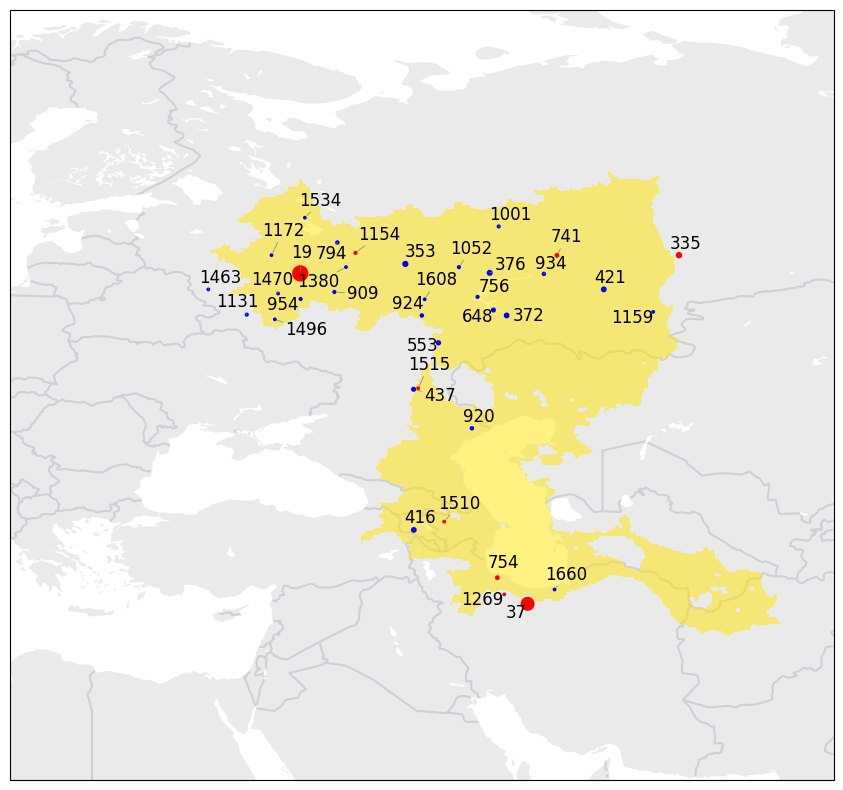

In [151]:
#############################################################
# 都市の位置と河川の配置と流域範囲を示す地図をプロットしたい
#############################################################

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.colors as mcolors
from adjustText import adjust_text

def geography(left, right, bottom, top):
    #
    resolution = 12
    #
    upperindex = (90-top)*resolution
    lowerindex = (90-bottom)*resolution
    leftindex = (180+left)*resolution
    rightindex = (180+right)*resolution
    #
    rgnshape = (lowerindex-upperindex, rightindex-leftindex)
    #
    img_extent = (left, right, bottom, top)
    
    return upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent

def main_plot(left, right, bottom, top, uid=3, linewidth=5, padding=0.1):
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)

    # riv
    rivnum_path = f'{h08dir}/global_city/dat/riv_num_/rivnum.CAMA.gl5'
    rivnum = np.fromfile(rivnum_path, dtype='float32').reshape(2160, 4320) 
    rivnum_cropped = rivnum[upperindex:lowerindex, leftindex:rightindex]
    rivnum_masked = np.ma.masked_where(rivnum_cropped != uid, rivnum_cropped)
    
    # lonlat
    lonlat_path = f'{h08dir}/wsi/dat/cmy/cmy_citylonlat.npy'
    citylonlat = np.load(lonlat_path)

    nums = citylonlat[:, 0]
    lons = citylonlat[:, 1]
    lats = citylonlat[:, 2]
    mpcy = citylonlat[:, 3]

    # sort
    sorted_order = topological_sort(edges)
    sorted_index = []
    for cnm in sorted_order:
        idx = np.where(np.array(nums) == cnm)[0]
        sorted_index.append(idx)

    target_lons = lons[sorted_index]
    target_lats = lats[sorted_index]
    target_mpcy = mpcy[sorted_index]

    # population
    updown_path = f'{h08dir}/wsi/dat/availablewater/updown_availability_100km_abandon.txt'
    df_new = pd.read_csv(updown_path, delimiter='|', header=None)
    df_new.columns = df_new.iloc[0]
    df_new = df_new[1:].reset_index(drop=True)
    df_new = df_new.infer_objects()
    
    population = [df_new.loc[df_new['index'] == f'{city_num}', 'pop'].values[0] for city_num in sorted_order]
    population = [int(float(i)/1e5) for i in population]
    
    # cmap
    bounds = [0, 1000]
    cmap = mcolors.ListedColormap(['red', 'blue'])
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    rivnum_cmap = mcolors.ListedColormap(['#ffe500'])
    river_cmap = mcolors.ListedColormap(['#57acff'])

    # draw
    plt.rcParams["font.size"] = 50
    projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(20,10), subplot_kw={'projection': projection})
    ax.set_extent([left, right, bottom, top])

    bg = ax.imshow(rivnum_masked, 
                   alpha=0.5, cmap=rivnum_cmap, transform=ccrs.PlateCarree(), extent=img_extent
                  )
    
    img = ax.scatter(target_lons, target_lats, c=target_mpcy, s=population,
                     cmap=cmap, norm=norm, transform=ccrs.PlateCarree()
                    )

    texts = []
    for i, txt in enumerate(sorted_index):
        texts.append(ax.text(target_lons[i], target_lats[i], str(int(nums[txt])), fontsize=12, ha='right'))

    adjust_text(texts, only_move={'points': 'xy', 'text': 'xy'}, arrowprops=dict(arrowstyle='-', color='grey', lw=0.5))
    
    ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#eaeaea', zorder=-3)
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#ffffff')
    ax.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#ffffff', zorder=-1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.1,edgecolor='#d0cfd4')
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5, edgecolor='#d0cfd4', zorder=-3)
    ax.gridlines(visible=False)
    
    #cbar = fig.colorbar(imd, ax=ax, orientation='horizontal', pad=0.02)
    plt.show()

left, right, bottom, top = 20, 70, 25, 70
main_plot(left, right, bottom, top)

#[1154, 1159, 19, 1172, 924, 37, 1463, 954, 
#  335, 1496, 1380, 741, 1510, 1131, 1515, 1269, 
#  1534, 1608, 1660, 421, 1001, 416, 1470, 754, 
#  794, 934, 909, 353, 1052, 376, 756, 648, 372, 553, 437, 920
#]


coord_init [371 374]
Sorted order of cities from upstream to downstream
[1154, 1159, 19, 1172, 924, 37, 1463, 954, 335, 1496, 1380, 741, 1510, 1131, 1515, 1269, 1534, 1608, 1660, 421, 1001, 416, 1470, 754, 794, 934, 909, 353, 1052, 376, 756, 648, 372, 553, 437, 920]
------------------------------------------------------------------


/tmp/ipykernel_11448/3268889884.py:114: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  texts.append(ax.text(target_lons[i], target_lats[i], str(int(nums[txt])), fontsize=12, ha='right'))


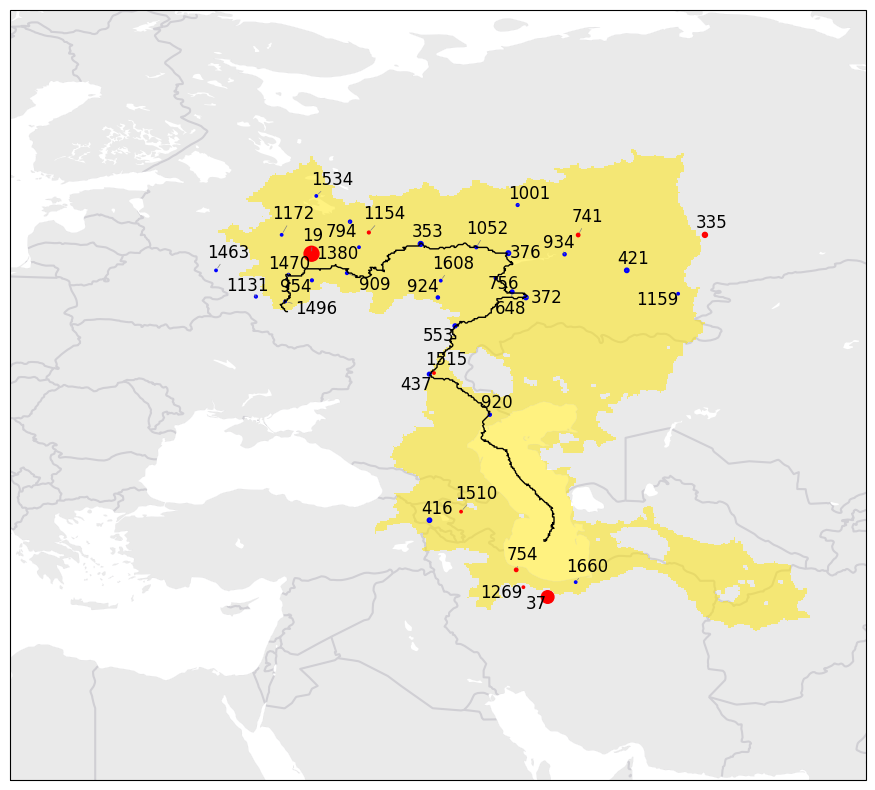

In [219]:
#############################################################
# 都市の位置と河川の配置と流域範囲を示す地図をプロットしたい
#############################################################

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.colors as mcolors
from adjustText import adjust_text

def geography(left, right, bottom, top):
    #
    resolution = 12
    #
    upperindex = (90-top)*resolution
    lowerindex = (90-bottom)*resolution
    leftindex = (180+left)*resolution
    rightindex = (180+right)*resolution
    #
    rgnshape = (lowerindex-upperindex, rightindex-leftindex)
    #
    img_extent = (left, right, bottom, top)
    
    return upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent

def main_plot(left, right, bottom, top, uid=3, linewidth=5, padding=0.1):
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)

    # riv
    rivnum_path = f'{h08dir}/global_city/dat/riv_num_/rivnum.CAMA.gl5'
    rivnum = np.fromfile(rivnum_path, dtype='float32').reshape(2160, 4320) 
    rivnum_cropped = rivnum[upperindex:lowerindex, leftindex:rightindex]
    rivnum_masked = np.ma.masked_where(rivnum_cropped != uid, rivnum_cropped)
    
    # discharge
    riv_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
    rivout = np.fromfile(riv_path, dtype='float32').reshape(2160, 4320)
    rivout_cropped = rivout[upperindex:lowerindex, leftindex:rightindex] * 60 * 60 * 24 * 365 / 1000
    rivout_masked = np.ma.masked_where(rivout_cropped==0, rivout_cropped)
    #rivout_thres = np.ma.masked_where(rivout_masked<threshold, rivout_masked)

    # rivnxl
    path_coords = get_rivpath(uid, upperindex, lowerindex, leftindex, rightindex)

    # lonlat
    lonlat_path = f'{h08dir}/wsi/dat/cmy/cmy_citylonlat.npy'
    citylonlat = np.load(lonlat_path)

    nums = citylonlat[:, 0]
    lons = citylonlat[:, 1]
    lats = citylonlat[:, 2]
    mpcy = citylonlat[:, 3]

    # sort
    sorted_order = topological_sort(edges)
    sorted_index = []
    for cnm in sorted_order:
        idx = np.where(np.array(nums) == cnm)[0]
        sorted_index.append(idx)

    target_lons = lons[sorted_index]
    target_lats = lats[sorted_index]
    target_mpcy = mpcy[sorted_index]

    # population
    updown_path = f'{h08dir}/wsi/dat/availablewater/updown_availability_100km_abandon.txt'
    df_new = pd.read_csv(updown_path, delimiter='|', header=None)
    df_new.columns = df_new.iloc[0]
    df_new = df_new[1:].reset_index(drop=True)
    df_new = df_new.infer_objects()
    
    population = [df_new.loc[df_new['index'] == f'{city_num}', 'pop'].values[0] for city_num in sorted_order]
    population = [int(float(i)/1e5) for i in population]

    # cmap
    bounds = [0, 1000]
    cmap = mcolors.ListedColormap(['red', 'blue'])
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    rivnum_cmap = mcolors.ListedColormap(['#ffe500'])
    river_cmap = mcolors.ListedColormap(['#57acff'])

    # draw
    plt.rcParams["font.size"] = 50
    projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(20,10), subplot_kw={'projection': projection})
    ax.set_extent([left, right, bottom, top], ccrs.PlateCarree())

    # rivnxl
    width = 1

    lat_coords, lon_coords = zip(*path_coords)
    lat_coords = [img_extent[3] - ((lat + (1/(width * 2)))*(1/12)) for lat in lat_coords]
    lon_coords = [(lon + (1/(width * 2)))*(1/12) + img_extent[0] for lon in lon_coords]
    ax.plot(lon_coords, lat_coords, 
            markersize=0, linewidth=1, color='black',
            marker='o', linestyle='-', transform=ccrs.PlateCarree(), zorder=2)

    # rivnum
    bg = ax.imshow(rivnum_masked, 
                   alpha=0.5, cmap=rivnum_cmap, transform=ccrs.PlateCarree(), extent=img_extent
                  )

    # lonlat
    img = ax.scatter(target_lons, target_lats, c=target_mpcy, s=population,
                     cmap=cmap, norm=norm, transform=ccrs.PlateCarree()
                    )

    # text
    texts = []
    for i, txt in enumerate(sorted_index):
        texts.append(ax.text(target_lons[i], target_lats[i], str(int(nums[txt])), fontsize=12, ha='right'))

    adjust_text(texts, only_move={'points': 'xy', 'text': 'xy'}, arrowprops=dict(arrowstyle='-', color='grey', lw=0.5))
    
    ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#eaeaea', zorder=-3)
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#ffffff')
    ax.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#ffffff', zorder=-1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.1,edgecolor='#d0cfd4')
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5, edgecolor='#d0cfd4', zorder=-3)
    ax.gridlines(visible=False)
    
    #cbar = fig.colorbar(imd, ax=ax, orientation='horizontal', pad=0.02)
    plt.show()

left, right, bottom, top = 20, 70, 25, 70
main_plot(left, right, bottom, top)